<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/BOW_FCNN/Covid19FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import kagglehub
import os

In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Kaggle dataset download
path = kagglehub.dataset_download("invalizare/covid-19-fake-news-dataset")
dataset_dir = "/root/.cache/kagglehub/datasets/invalizare/covid-19-fake-news-dataset/"

# Dynamically locate CSV
file_name = None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Val.csv" in file:
            file_name = os.path.join(root, file)
            break

# Load the dataset
df = pd.read_csv(file_name)

print("Dataset preview:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

# missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
df.dropna(subset=['tweet', 'label'], inplace=True)

# Rename columns
df.rename(columns={'tweet': 'text', 'label': 'label'}, inplace=True)

# Display renamed dataset
print("\nRenamed dataset preview:")
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


100%|██████████| 832k/832k [00:00<00:00, 73.6MB/s]

Extracting files...
Dataset preview:
   id                                              tweet label
0   1  Chinese converting to Islam after realising th...  fake
1   2  11 out of 13 people (from the Diamond Princess...  fake
2   3  COVID-19 Is Caused By A Bacterium, Not Virus A...  fake
3   4  Mike Pence in RNC speech praises Donald Trump’...  fake
4   5  6/10 Sky's @EdConwaySky explains the latest #C...  real

Dataset statistics:
                id
count  2140.000000
mean   1070.500000
std     617.909109
min       1.000000
25%     535.750000
50%    1070.500000
75%    1605.250000
max    2140.000000

Missing values per column:
id       0
tweet    0
label    0
dtype: int64

Renamed dataset preview:
   id                                               text label
0   1  Chinese converting to Islam after realising th...  fake
1   2  11 out of 13 people (from the Diamond Princess...  fake
2   3  COVID-19 Is Caused By A Bacterium, Not Virus A...  fake
3   4  Mike Pence in RNC speech praises D

In [3]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

# Add filtering
new_data = []
new_labels = []
for text, label in zip(df['processed_text'], df['label']):
    if len(text) > 50 and text not in new_data:
        new_data.append(text)
        new_labels.append(label)

filtered_df = pd.DataFrame({'text': new_data, 'label': new_labels})

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['text'], filtered_df['label'], test_size=0.2, random_state=42
)


In [4]:
# find unique labels
print("Unique labels in the dataset before mapping:")
print(filtered_df['label'].unique())

# Update label mapping
label_mapping = {'fake': 0, 'real': 1}

# Map strings to numbers
filtered_df['label'] = filtered_df['label'].map(label_mapping)

# Check for unmapped/ invalid labels
if filtered_df['label'].isnull().any():
    print("Error: Unmapped or invalid labels detected.")
    print("Label Distribution Before Drop:")
    print(filtered_df['label'].value_counts(dropna=False))
    filtered_df = filtered_df.dropna(subset=['label'])

filtered_df['label'] = filtered_df['label'].astype(int)

print("Final Label Distribution:")
print(filtered_df['label'].value_counts())

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['text'], filtered_df['label'], test_size=0.2, random_state=42
)

# Tfidf Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

# Convert labels to tensors
train_labels = torch.tensor(train_labels.values, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), train_labels)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Unique labels in the dataset before mapping:
['fake' 'real']
Final Label Distribution:
label
1    1120
0     959
Name: count, dtype: int64


In [5]:
# Define NN
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 2

model = TextClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.numpy())
        y_true.extend(y_batch.numpy())

Epoch 1/10, Loss: 32.2031
Epoch 2/10, Loss: 16.4015
Epoch 3/10, Loss: 7.0229
Epoch 4/10, Loss: 3.5030
Epoch 5/10, Loss: 1.9475
Epoch 6/10, Loss: 1.1858
Epoch 7/10, Loss: 0.7751
Epoch 8/10, Loss: 0.5412
Epoch 9/10, Loss: 0.3986
Epoch 10/10, Loss: 0.3044



Model Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.87      0.89       195
        True       0.89      0.91      0.90       221

    accuracy                           0.89       416
   macro avg       0.89      0.89      0.89       416
weighted avg       0.89      0.89      0.89       416



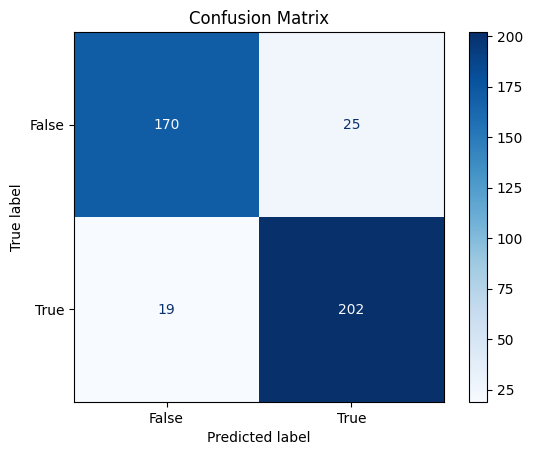


Sample Predictions:

Sample 1
Text: social media posts attribute a list of points about the novel coronavirus to johns hopkins a leading source of information on the virus
Predicted: False, Actual: False

Sample 2
Text: focus on good nutrition as a part of selfcare during the covid19 pandemic certain vitamins amp minerals may have effects on how the immune system works to fight off infections amp inflammation you can obtain these nutrients through food learn more httpstcoywoxx6vjhk httpstcoy8ynpil6q2
Predicted: True, Actual: True

Sample 3
Text: indiafightscorona not only is indias case fatality rate lower than the global average currently is 174 but a very small proportion of the active cases amounting to less than 05 are on ventilator support 2 cases are in icus amp less than 35 are on oxygen support httpstcozqasqsbz0v
Predicted: True, Actual: True

Sample 4
Text: as of june 16 more than 21 million covid19 cases have been reported in the us with 37 states and jurisdictions reporting

In [6]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['False', 'True']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Display a few predictions
print("\nSample Predictions:")
for i, (text, pred, true_label) in enumerate(zip(test_texts[:5], y_pred[:5], test_labels[:5])):
    print(f"\nSample {i+1}")
    print(f"Text: {text}")
    print(f"Predicted: {'True' if pred else 'False'}, Actual: {'True' if true_label else 'False'}")